## Imports

In [2]:
from pyspark.sql import DataFrame, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType, LongType, DoubleType, ArrayType, DateType
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import ArrayType, StringType, MapType, IntegerType

## Create Spark session

In [4]:
from dtu_ctfds_02807_proj.context_creation import create_context

local = True
sc, spark = create_context(local)

Already been executed once, not running again!


## Load data

In [ ]:
review_schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("app_id", LongType(), True),
    StructField("app_name", StringType(), True),
    StructField("review_id", LongType(), True),
    StructField("language", StringType(), True),
    StructField("review", StringType(), True),
    StructField("timestamp_created", IntegerType(), True),
    StructField("timestamp_updated", IntegerType(), True),
    StructField("recommended", BooleanType(), True),
    StructField("votes_helpful", IntegerType(), True),
    StructField("votes_funny", IntegerType(), True),
    StructField("weighted_vote_score", DoubleType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("steam_purchase", BooleanType(), True),
    StructField("received_for_free", BooleanType(), True),
    StructField("written_during_early_access", BooleanType(), True),
    StructField("author_steamid", LongType(), True),
    StructField("author_num_games_owned", IntegerType(), True),
    StructField("author_num_reviews", IntegerType(), True),
    StructField("author_playtime_forever", DoubleType(), True),
    StructField("author_playtime_last_two_weeks", DoubleType(), True),
    StructField("author_playtime_at_review", DoubleType(), True),
    StructField("author_last_played", DoubleType(), True)
])

In [ ]:
game_schema = StructType([
    StructField("app_id", LongType(), True),
    StructField("name", StringType(), True),
    StructField("release_date", DateType(), True),
    StructField("required_age", IntegerType(), True),
    StructField("price", FloatType(), True),
    StructField("dlc_count", IntegerType(), True),
    StructField("detailed_description", StringType(), True),
    StructField("about_the_game", StringType(), True),
    StructField("short_description", StringType(), True),
    StructField("reviews", StringType(), True),
    StructField("header_image", StringType(), True),
    StructField("website", StringType(), True),
    StructField("support_url", StringType(), True),
    StructField("support_email", StringType(), True),
    StructField("windows", BooleanType(), True),
    StructField("mac", BooleanType(), True),
    StructField("linux", BooleanType(), True),
    StructField("metacritic_score", IntegerType(), True),
    StructField("metacritic_url", StringType(), True),
    StructField("achievements", IntegerType(), True),
    StructField("recommendations", IntegerType(), True),
    StructField("notes", StringType(), True),
    StructField("supported_languages", StringType(), True),  # Will be parsed as ArrayType
    StructField("full_audio_languages", StringType(), True),  # Will be parsed as ArrayType
    StructField("packages", StringType(), True),  # Will be parsed as ArrayType
    StructField("developers", StringType(), True),  # Will be parsed as ArrayType
    StructField("publishers", StringType(), True),  # Will be parsed as ArrayType
    StructField("categories", StringType(), True),  # Will be parsed as ArrayType
    StructField("genres", StringType(), True),  # Will be parsed as ArrayType
    StructField("screenshots", StringType(), True),  # Will be parsed as ArrayType
    StructField("movies", StringType(), True),  # Will be parsed as ArrayType
    StructField("user_score", FloatType(), True),
    StructField("score_rank", IntegerType(), True),
    StructField("positive", IntegerType(), True),
    StructField("negative", IntegerType(), True),
    StructField("estimated_owners", StringType(), True),
    StructField("average_playtime_forever", IntegerType(), True),
    StructField("average_playtime_2weeks", IntegerType(), True),
    StructField("median_playtime_forever", IntegerType(), True),
    StructField("median_playtime_2weeks", IntegerType(), True),
    StructField("peak_ccu", IntegerType(), True),
    StructField("tags", StringType(), True),  # Will be parsed as MapType
    StructField("pct_pos_total", IntegerType(), True),
    StructField("num_reviews_total", IntegerType(), True),
    StructField("pct_pos_recent", IntegerType(), True),
    StructField("num_reviews_recent", IntegerType(), True)
])

game_schema = StructType([
    StructField("AppID", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("release_date", DateType(), True),
    StructField("required_age", IntegerType(), True),
    StructField("price", FloatType(), True),
    StructField("dlc_count", IntegerType(), True),
    StructField("detailed_description", StringType(), True),
    StructField("about_the_game", StringType(), True),
    StructField("short_description", StringType(), True),
    StructField("reviews", StringType(), True),
    StructField("header_image", StringType(), True),
    StructField("website", StringType(), True),
    StructField("support_url", StringType(), True),
    StructField("support_email", StringType(), True),
    StructField("windows", BooleanType(), True),
    StructField("mac", BooleanType(), True),
    StructField("linux", BooleanType(), True),
    StructField("metacritic_score", IntegerType(), True),
    StructField("metacritic_url", StringType(), True),
    StructField("achievements", IntegerType(), True),
    StructField("recommendations", IntegerType(), True),
    StructField("notes", StringType(), True),
    StructField("supported_languages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("full_audio_languages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("packages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("developers", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("publishers", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("categories", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("genres", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("screenshots", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("movies", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("user_score", FloatType(), True),
    StructField("score_rank", IntegerType(), True),
    StructField("positive", IntegerType(), True),
    StructField("negative", IntegerType(), True),
    StructField("estimated_owners", StringType(), True),
    StructField("average_playtime_forever", IntegerType(), True),
    StructField("average_playtime_2weeks", IntegerType(), True),
    StructField("median_playtime_forever", IntegerType(), True),
    StructField("median_playtime_2weeks", IntegerType(), True),
    StructField("peak_ccu", IntegerType(), True),
    StructField("tags", MapType(StringType(), IntegerType()), True),  # Parsed from JSON
    StructField("pct_pos_total", IntegerType(), True),
    StructField("num_reviews_total", IntegerType(), True),
    StructField("pct_pos_recent", IntegerType(), True),
    StructField("num_reviews_recent", IntegerType(), True)
])

In [ ]:

games = spark\
    .read\
    .option("escapeQuotes", "true")\
    .csv('data/steam_games_flattened.csv', header=True, schema=game_schema, quote='"', escape='"')


In [ ]:
array_schema = ArrayType(StringType())
map_schema = MapType(StringType(), IntegerType())

# Parse the JSON fields
games = games.withColumn("supported_languages", from_json(col("supported_languages"), array_schema)) \
       .withColumn("full_audio_languages", from_json(col("full_audio_languages"), array_schema)) \
       .withColumn("packages", from_json(col("packages"), array_schema)) \
       .withColumn("developers", from_json(col("developers"), array_schema)) \
       .withColumn("publishers", from_json(col("publishers"), array_schema)) \
       .withColumn("categories", from_json(col("categories"), array_schema)) \
       .withColumn("genres", from_json(col("genres"), array_schema)) \
       .withColumn("screenshots", from_json(col("screenshots"), array_schema)) \
       .withColumn("movies", from_json(col("movies"), array_schema)) \
       .withColumn("tags", from_json(col("tags"), map_schema))


In [63]:
games.count()

83646

In [ ]:
# games\
#     .write\
#     .parquet('data/steam_games_parquet')

In [6]:

if local:
    game_reviews = spark.read.parquet("data/steam_reviews_sample_parquet")
    games = spark.read.parquet("data/steam_games_parquet")
else:
    # Read csv comma separated with specified schema
    # game_reviews = spark.read\
    #     .option("escapeQuotes", "true")\
    #     .csv('file:////work/ds/steam_reviews_flattened.csv', header=True, schema=review_schema, quote='"', escape='"')
    game_reviews = spark.read.parquet("file:////work/ds/steam_reviews_parquet")

    # games = spark.read.csv('file:////work/ds/steam-games.csv', header=True, schema=game_schema)
    games = spark.read.parquet('file:////work/ds/steam_games_parquet')
    

game_reviews: DataFrame = game_reviews.persist()
games: DataFrame = games.persist()

In [8]:
# game_reviews_sample = game_reviews.sample(False, 100000/(21 * 10 ** 6), seed=1234)
# game_reviews_sample = game_reviews_sample.persist()

In [9]:
# game_reviews.write.parquet("file:////work/ds/steam_reviews_parquet")
# games.write.parquet("file:////work/ds/steam_games_parquet")

In [71]:
game_reviews\
    .select(game_reviews.app_id)\
    .distinct()\
    .count()

315

In [72]:
game_reviews\
    .show(5)

+-------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|  index|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+-------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----

In [73]:
game_reviews\
    .select(game_reviews.app_id)\
    .filter(game_reviews.language == 'english')\
    .count()

46020

## Most reviewed games

In [13]:
most_reviewed = game_reviews\
    .groupBy(game_reviews.app_id)\
    .agg(
        F.count('review_id').alias('review_count'),
        F.count(
            F.when(game_reviews.recommended == True, 1)
        ).alias('recommended_count'),
        F.count(
            F.when(game_reviews.recommended == False, 1)
        ).alias('not_recommended_count')
    )\
    .withColumn(
        'recommended_ratio',
        F.col('recommended_count') / F.col('review_count')
    )\
    .withColumn(
        'not_recommended_ratio',
        F.col('not_recommended_count') / F.col('review_count')
    )\
    .withColumn(
        'recommended_to_not_recommended_ratio',
        F.col('recommended_count') / F.col('not_recommended_count')
    )

most_reviewed_games = most_reviewed\
    .join(games, most_reviewed.app_id == games.app_id)


In [14]:
most_reviewed_games\
    .select('title', 'review_count', 'recommended_ratio', 'recommended_to_not_recommended_ratio')\
    .orderBy(F.desc('review_count'))\
    .show(
        5,
        truncate=False
    )

+-------------------------------+------------+------------------+------------------------------------+
|title                          |review_count|recommended_ratio |recommended_to_not_recommended_ratio|
+-------------------------------+------------+------------------+------------------------------------+
|PUBG: BATTLEGROUNDS            |7835        |0.5392469687300574|1.1703601108033241                  |
|Grand Theft Auto V             |4913        |0.8155912884184816|4.422737306843267                   |
|Tom Clancy's Rainbow Six® Siege|3981        |0.8839487565938207|7.616883116883117                   |
|Terraria                       |3084        |0.9727626459143969|35.714285714285715                  |
|Garry's Mod                    |3079        |0.9600519649236765|24.03252032520325                   |
+-------------------------------+------------+------------------+------------------------------------+
only showing top 5 rows



In [15]:
most_reviewed_games\
    .select('title', 'review_count', 'recommended_ratio', 'recommended_to_not_recommended_ratio')\
    .filter(F.col('recommended_to_not_recommended_ratio').isNotNull())\
    .filter(F.col('review_count') > 100)\
    .orderBy(F.asc('recommended_to_not_recommended_ratio'))\
    .show(
        5,
        truncate=False
    )

+-------------------+------------+------------------+------------------------------------+
|title              |review_count|recommended_ratio |recommended_to_not_recommended_ratio|
+-------------------+------------+------------------+------------------------------------+
|ATLAS              |192         |0.4791666666666667|0.92                                |
|Call of Duty®: WWII|141         |0.524822695035461 |1.1044776119402986                  |
|PUBG: BATTLEGROUNDS|7835        |0.5392469687300574|1.1703601108033241                  |
|Artifact           |113         |0.5575221238938053|1.26                                |
|No Man's Sky       |896         |0.6796875         |2.1219512195121952                  |
+-------------------+------------+------------------+------------------------------------+
only showing top 5 rows



## Review count by user

In [16]:
reviews_by_user = game_reviews\
    .groupBy("author_steamid")\
    .agg(
        F.count('review_id').alias('review_count'),
    )

user_review_count = reviews_by_user\
    .groupBy("review_count")\
    .agg(
        F.count('review_count').alias('user_count'),
    )\
    .orderBy(F.desc('review_count'))

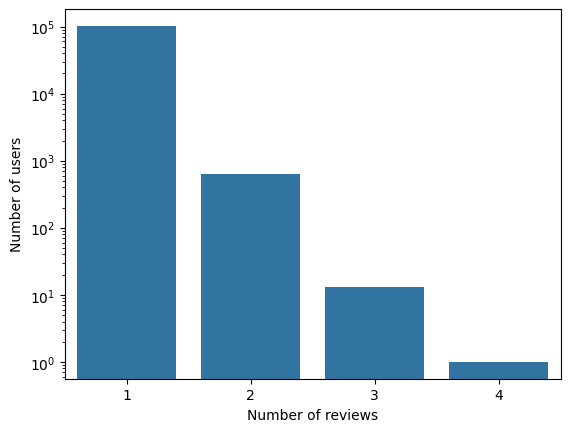

In [17]:
user_review_count_pd = user_review_count.toPandas()

# Only discrete values, log y-axis
sns.barplot(
    x=user_review_count_pd['review_count'],
    y=user_review_count_pd['user_count'],
    log=True
)
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')

plt.show()

## Histogram of review_count

In [18]:
most_reviewed_games_pdf = most_reviewed_games.toPandas()

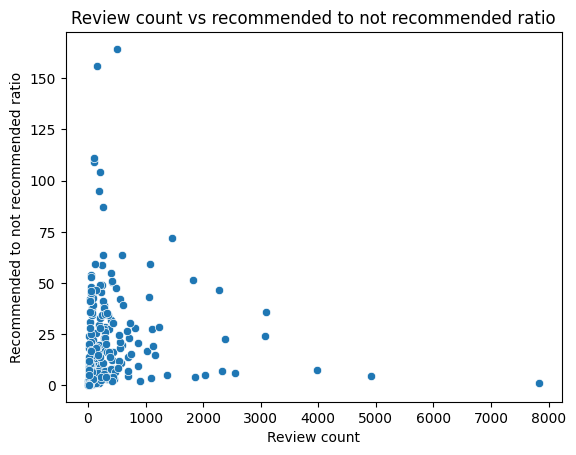

In [19]:
sns.scatterplot(
    x='review_count',
    y='recommended_to_not_recommended_ratio',
    data=most_reviewed_games_pdf
)

plt.xlabel('Review count')
plt.ylabel('Recommended to not recommended ratio')
plt.title('Review count vs recommended to not recommended ratio')
plt.show()

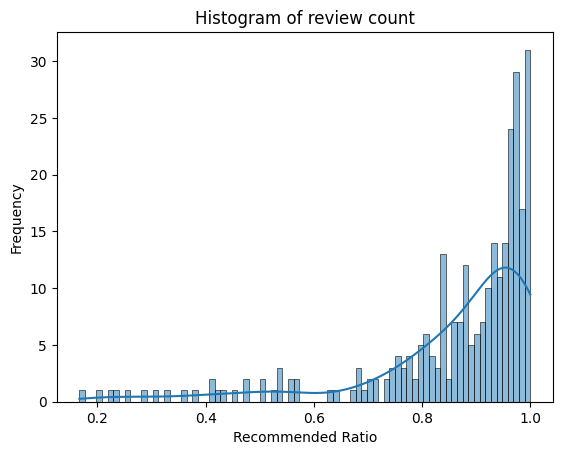

In [20]:
sns.histplot(
    most_reviewed_games_pdf['recommended_ratio'],
    bins=80,
    kde=True
)
plt.xlabel('Recommended Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of review count')
plt.show()

In [21]:
game_reviews\
    .filter(game_reviews.author_steamid > 100)\
    .groupBy(game_reviews.app_id, game_reviews.author_steamid)\
    .agg(
        F.count('review_id').alias('review_count'),
    )\
    .orderBy(F.desc('review_count'))\
    .show(
        5
    )

+-------+-----------------+------------+
| app_id|   author_steamid|review_count|
+-------+-----------------+------------+
| 367520|76561198988312667|           2|
| 227300|76561198079793673|           2|
| 779340|76561198156707503|           1|
| 779340|76561198022192588|           1|
|1190460|76561198080232836|           1|
+-------+-----------------+------------+
only showing top 5 rows



# Collaborative filtering

## ALS model

In [8]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer

game_ratings = game_reviews\
    .filter(F.col("author_steamid").isNotNull())\
    .withColumn(
        'rating',
        F.when(game_reviews.recommended == True, 1).otherwise(-1)
    )

user_indexer = StringIndexer(inputCol="author_steamid", outputCol="user_index")
game_ratings = user_indexer.fit(game_ratings).transform(game_ratings)

reviews_train, reviews_test = game_ratings\
    .randomSplit([0.8, 0.2], seed=1234)

als = ALS(
    maxIter=50,
    rank=20,
    regParam=0.01,
    userCol="user_index",
    itemCol="app_id",
    ratingCol="rating",
    coldStartStrategy="drop"
)

In [9]:
model = als.fit(reviews_train)

predictions = model.transform(reviews_test).cache()

In [10]:
# Round predictions to -1 or 1
rounded_pred = predictions\
    .withColumn(
        'prediction',
        F.when(F.col('prediction') > 0, 1.).otherwise(-1.)
    )\
    .select('rating', 'prediction')\

rounded_pred.show(5)

+------+----------+
|rating|prediction|
+------+----------+
|     1|      -1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 5 rows



In [11]:
# Calculate RMSE
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(rounded_pred)
print(f"Root-mean-square error = {rmse}")

# Calculate accuracy
correct = rounded_pred\
    .filter(F.col('rating') == F.col('prediction'))\
    .count()

total = rounded_pred.count()

accuracy = correct / total

print(f"Accuracy = {accuracy}")

Root-mean-square error = 1.3575462928286368


Accuracy = 0.5392670157068062


# Content based filtering

In [8]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, BucketedRandomProjectionLSH, BucketedRandomProjectionLSHModel, MinHashLSH, MinHashLSHModel
from pyspark.ml import Pipeline

In [33]:
features = games\
    .withColumn(
        "text",
        F.concat_ws(
            " ",
            games.title,
            games.genres,
            games.categories,
            games.developer,
            games.publisher,
            games.content_descriptor,
            games.about_description,
        )
    )

tokenizer = Tokenizer(inputCol="text", outputCol="words")

stop_word_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)

idf = IDF(inputCol="rawFeatures", outputCol="features")

brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=10.0)

pipeline = Pipeline(stages=[tokenizer, stop_word_remover, hashingTF, idf, brp])


In [34]:
model = pipeline.fit(features)

In [35]:
result = model.transform(features)

In [36]:
brp_model: BucketedRandomProjectionLSHModel = model.stages[-1]

In [37]:
query_vector = result\
    .where(F.col('app_id') == 10)\
    .select('features')\
    .first()

brp_model\
    .approxNearestNeighbors(
        dataset=result, 
        key=query_vector["features"],
        numNearestNeighbors=5,
        distCol="EuclideanDistance" 
    )\
    .show()

+------+--------------------+------------+----------------+--------------------+-----------+------------+--------------+-------------------+----------------+-------------+----------+------------------+--------------------+-----------+-----------+-------------+------+--------------------+-------------------------+--------------------+--------------------+------------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+------------------+
|app_id|               title|release_date|          genres|          categories|  developer|   publisher|original_price|discount_percentage|discounted_price|dlc_available|age_rating|content_descriptor|   about_description|win_support|mac_support|linux_support|awards|      overall_review|overall_review_percentage|overall_review_count|       recent_review|recent_review_percentage|recent_review_count|                text|               words|            filtered| 

In [ ]:
left = result.alias("left")
right = result.alias("right")

similar_games = brp_model\
    .approxSimilarityJoin(
        left, right, threshold=0.0, distCol="EuclideanDistance"
    )\
    .filter(F.col("datasetA.app_id") < F.col("datasetB.app_id"))\
    
similar_games\
    .select(
        "datasetA.app_id",
        "datasetB.app_id",
        "EuclideanDistance"
    ).show()



[287.854s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 463.0 (TID 1964): Retried waiting for GCLocker too often allocating 256 words
[287.915s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 468.0 (TID 1974): Retried waiting for GCLocker too often allocating 256 words
[287.915s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 458.0 (TID 1954): Retried waiting for GCLocker too often allocating 389 words
[289.911s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 458.0 (TID 1955): Retried waiting for GCLocker too often allocating 38 words
[290.111s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 468.0 (TID 1975): Retried waiting for GCLocker too often allocating 430 words
[290.112s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 458.0 (TID 1954): Retried waiting for GCLocker too often allocating 416 words
[290.176s][warning][gc,alloc] Executor task launch wo

24/11/17 20:47:30 ERROR Utils: uncaught error in thread spark-listener-group-appStatus, stopping SparkContext
java.lang.OutOfMemoryError: Java heap space
24/11/17 20:47:30 ERROR Utils: throw uncaught fatal error in thread spark-listener-group-appStatus
java.lang.OutOfMemoryError: Java heap space
Exception in thread "spark-listener-group-appStatus" java.lang.OutOfMemoryError: Java heap space
24/11/17 20:47:30 ERROR Executor: Exception in task 1.0 in stage 458.0 (TID 1955)
java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.catalyst.expressions.UnsafeArrayData.toDoubleArray(UnsafeArrayData.java:414)
	at org.apache.spark.ml.linalg.VectorUDT.deserialize(VectorUDT.scala:63)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.encoders.ExpressionEncoder$Deserializer.apply(ExpressionEncoder.scala:188)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.$anonfun$scalaConverter$2(ScalaUDF.

Py4JJavaError: An error occurred while calling o497.showString.
: org.apache.spark.SparkException: Job 36 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1251)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1251)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3087)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:2973)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2973)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2258)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2258)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2211)
	at org.apache.spark.SparkContext$$anon$3.run(SparkContext.scala:2198)


In [ ]:

# Select relevant columns for content-based filtering
game_data = games\
    .sample(False, 0.1, seed=1234)\
    .select("app_id", "name", "genres", "detailed_description")

# Preprocessing pipeline
# Tokenize the detailed description
tokenizer = Tokenizer(inputCol="detailed_description", outputCol="tokens")

# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Apply TF (Term Frequency)
hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=10)

# Apply IDF (Inverse Document Frequency)
idf = IDF(inputCol="raw_features", outputCol="features")

# Locality Sensitive Hashing (LSH) for similarity search
minhash_lsh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)

# Build the pipeline
pipeline = Pipeline(stages=[
    tokenizer,
    stopwords_remover,
    hashing_tf,
    idf,
    minhash_lsh
])


In [10]:
# Fit the pipeline to the data
model = pipeline.fit(game_data)
processed_games_df = model.transform(game_data)

24/11/17 22:26:47 ERROR Executor: Exception in task 6.0 in stage 2.0 (TID 8)/ 8]
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:71)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:391)
	at org.apache.spark.sql.execution.columnar.BasicColumnBuilder.initialize(ColumnBuilder.scala:68)
	at org.apache.spark.sql.execution.columnar.ComplexColumnBuilder.org$apache$spark$sql$execution$columnar$NullableColumnBuilder$$super$initialize(ColumnBuilder.scala:93)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize(NullableColumnBuilder.scala:51)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.initialize$(NullableColumnBuilder.scala:42)
	at org.apache.spark.sql.execution.columnar.ComplexColumnBuilder.initialize(ColumnBuilder.scala:93)
	at org.apache.spark.sql.execution.columnar.ColumnBuilder$.apply(ColumnBuilder.scala:203)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSeri

ConnectionRefusedError: [Errno 61] Connection refused

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/esben/dev/dtu/03semester/CTFDS/DTU-CTFDS-02807-PROJ/.venv/lib/python3.13/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.0_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
ConnectionResetError: [Errno 54] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/esben/dev/dtu/03semester/CTFDS/DTU-CTFDS-02807-PROJ/.venv/lib/python3.13/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/esben/dev/dtu/03semester/CTFDS/DTU-CTFDS-02807-PROJ/.venv/lib/python3.13/site

In [ ]:
# Show the processed data
processed_games_df.select("app_id", "name", "hashes").show(truncate=False)

# Example: Finding similar games based on detailed description
# Choose a game to find similar ones
sample_game = processed_games_df.filter(processed_games_df["name"] == "Sample Game Name").limit(1)

# Perform the similarity search
similar_games = model.stages[-1].approxSimilarityJoin(
    processed_games_df, sample_game, 0.8, distCol="JaccardDistance"
)

# Show similar games
similar_games.select("datasetA.name", "datasetB.name", "JaccardDistance").show(truncate=False)